## Advanced Lane Finding Project

The goals / steps of this project are the following:

* Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
* Apply a distortion correction to raw images.
* Use color transforms, gradients, etc., to create a thresholded binary image.
* Apply a perspective transform to rectify binary image ("birds-eye view").
* Detect lane pixels and fit to find the lane boundary.
* Determine the curvature of the lane and vehicle position with respect to center.
* Warp the detected lane boundaries back onto the original image.
* Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.

---
### First, I'll compute the camera calibration using chessboard images

In [1]:
import numpy as np
import cv2
import glob
import os
import pickle
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from moviepy.editor import VideoFileClip
from IPython.display import HTML

%matplotlib inline


# prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
objp = np.zeros((6*9,3), np.float32)
objp[:,:2] = np.mgrid[0:9,0:6].T.reshape(-1,2)

# Arrays to store object points and image points from all the images.
objpoints = [] # 3d points in real world space
imgpoints = [] # 2d points in image plane

# Make a list of calibration images
images = glob.glob('camera_cal/calibration*.jpg')


# Step through the list and search for chessboard corners
for fname in images:
    img = cv2.imread(fname)
    gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)

    # Find the chessboard corners
    ret, corners = cv2.findChessboardCorners(gray, (9,6),None)

    # If found, add object points, image points
    if ret == True:
        objpoints.append(objp)
        imgpoints.append(corners)

        # Draw and display the corners
        img = cv2.drawChessboardCorners(img, (9,6), corners, ret)
        cv2.imshow('img',img)
        cv2.waitKey(500)
        
        #do camera calibration given the object points and image points
        ret,mtx,dist,rvecs,tvecs = cv2.calibrateCamera(objpoints,imgpoints,gray.shape[::-1],None,None)
        
        #Save the camera calibration result for later use
        calibration = {}
        calibration["mtx"] = mtx
        calibration["dist"] = dist
        pickle.dump(calibration, open("calibration data/calibration.p", "wb"))
        
        


cv2.destroyAllWindows()


### And so on and now we have mtx(camera matrix) and dist(distortion coefficients), we'll use this to undistort the chessboard images

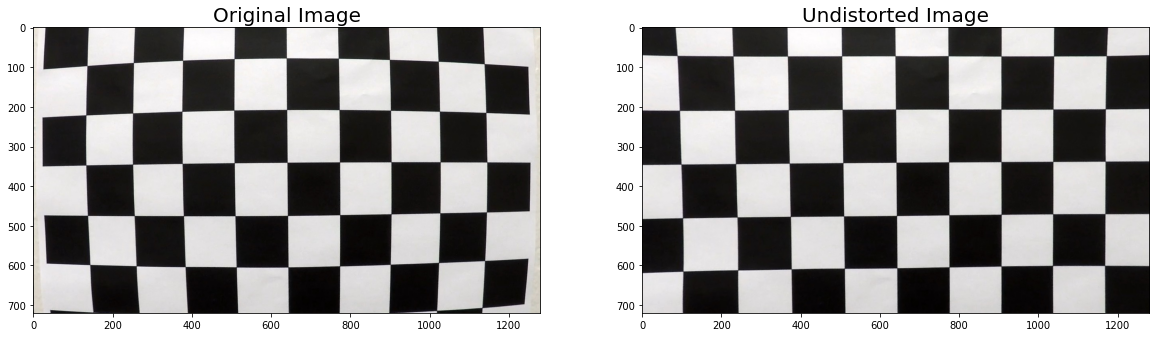

In [2]:
#read in the chessboard image to undistort it
img = mpimg.imread("camera_cal/calibration1.jpg")
    
#read in the saved mtx(camera matrix) and dist(distortion coefficients)
calibration_pickle = pickle.load(open("calibration data/calibration.p","rb"))
mtx = calibration_pickle["mtx"]
dist = calibration_pickle["dist"]
    
#Undistorting an image using mtx(camera matrix) and dist(distortion coefficients)
undist = cv2.undistort(img,mtx,dist,None,mtx)
    
f,(ax1,ax2) = plt.subplots(1,2, figsize = (20,10))
ax1.imshow(img)
ax1.set_title('Original Image', fontsize = 20)
ax2.imshow(undist)
ax2.set_title('Undistorted Image', fontsize = 20)   
    

#Create a distortion function for calling them later in lane detection pipeline
def cal_undistort(img):    
    
    #Undistorting an image using mtx(camera matrix) and dist(distortion coefficients)
    undist = cv2.undistort(img,mtx,dist,None,mtx)
    return undist



### Read in the test image 

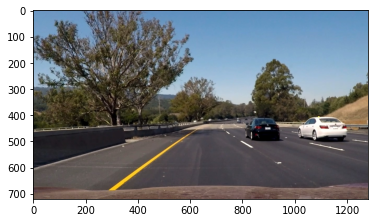

In [3]:
#Read the test image for lane detection 
test_image = mpimg.imread("test_images/test6.jpg")
plt.imshow(test_image)

### Apply distortion correction to the test image

Text(0.5, 1.0, 'Undistorted image')

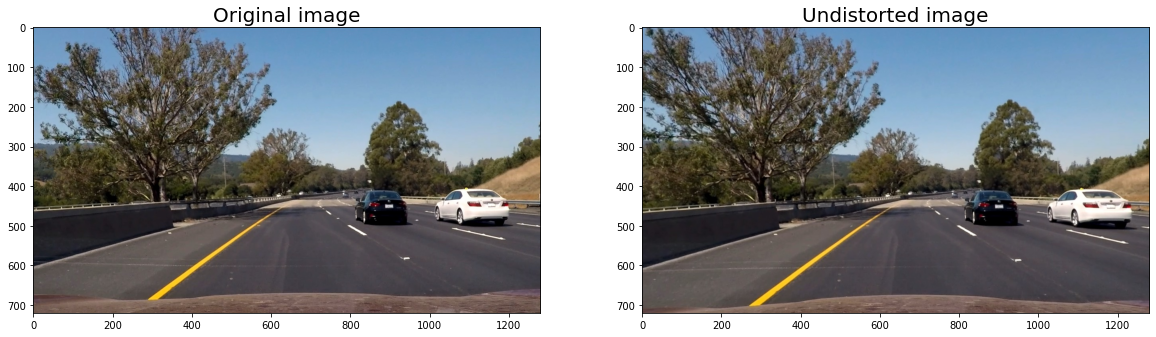

In [4]:
# Apply distortion correction to the test image
undistorted = cal_undistort(test_image)
f,(ax1,ax2) = plt.subplots(1,2, figsize = (20,10))
ax1.imshow(test_image)
ax1.set_title('Original image', fontsize = 20)
ax2.imshow(undistorted)
ax2.set_title('Undistorted image', fontsize = 20)

### Apply Perspective Transform to the test image for bird's eye view 
##### Assumption: Road is a flat plane and camera position is fixed

Text(0.5, 1.0, 'Warped')

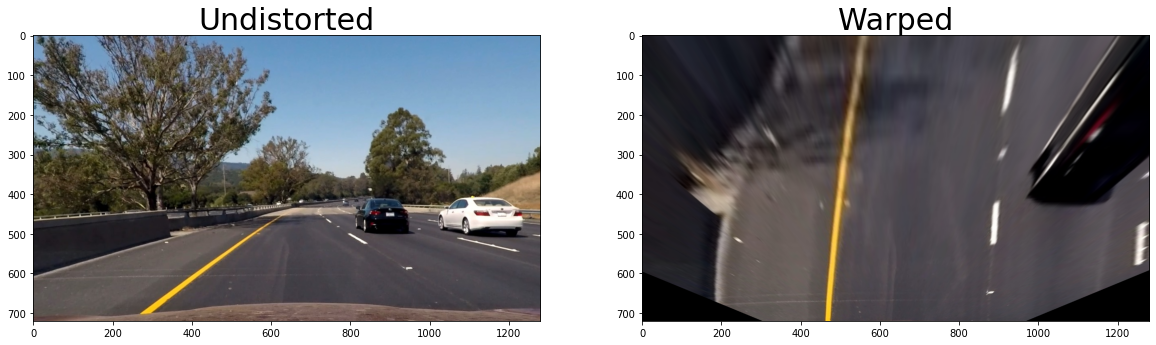

In [5]:
def perspective_transform(img,src,dst):
    img_size = (img.shape[1], img.shape[0])  
    #To find M, the transform matrix
    M = cv2.getPerspectiveTransform(src,dst)
    #To find Minv, the inverse transform matrix
    Minv = cv2.getPerspectiveTransform(dst,src)
    #Warping image to a top-down view
    warped = cv2.warpPerspective(img, M, img_size, flags=cv2.INTER_LINEAR)  
    return warped, M, Minv

#Visualize the perspective transform for test image

(h,w) = (undistorted.shape[0], undistorted.shape[1])

src = np.float32([(580,460),
                  (703,460), 
                  (262,675), 
                  (1036,675)])
dst = np.float32([(440,0),
                  (w-440,0),
                  (440,h),
                  (w-440,h)])

warped,M,Minv = perspective_transform(undistorted, src, dst)
f,(ax1,ax2) = plt.subplots(1,2, figsize = (20,10))
ax1.imshow(undistorted)
ax1.set_title('Undistorted', fontsize = 30)
ax2.imshow(warped)
ax2.set_title('Warped', fontsize = 30)


## Using color transforms and gradient thresholds to create a binary image

Text(0.5, 1.0, 'Thresholded binary')

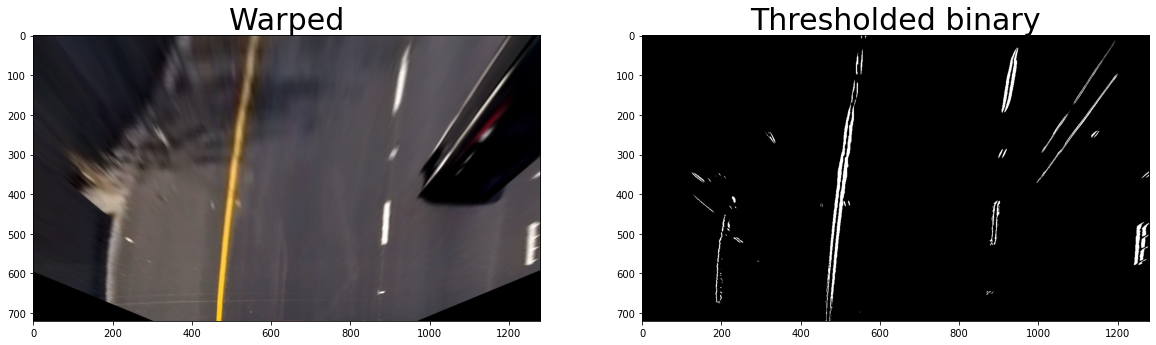

In [6]:

def threshold_binary_img(img, sobel_x_thresh = (25,127),hsv_v_thresh =(128,255)):
    
    # 1) Convert to grayscale
    gray = (cv2.cvtColor(img, cv2.COLOR_RGB2GRAY))
    # 2) Take the derivative in x orient     
    sobel = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize = 5)      
    # 3) Take the absolute value of the derivative or gradient
    abs_sobel = np.absolute(sobel)
    # 4) Scale to 8-bit (0 - 255) then convert to type = np.uint8
    scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))
    # 5) Create a mask of 1's where the scaled gradient magnitude 
            # is > thresh_min and < thresh_max
    sxbinary = np.zeros_like(scaled_sobel)
    sxbinary[(scaled_sobel >= sobel_x_thresh[0]) & (scaled_sobel <= sobel_x_thresh[1])] = 1
        
        
    # 1) Convert to HSV color space
    hsv = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
    # 2) Apply a threshold to the V channel
    hsv_v_binary = np.zeros_like(hsv[:,:,2])
    hsv_v_binary[(hsv[:,:,2] > hsv_v_thresh[0]) & (hsv[:,:,2] <= hsv_v_thresh[1])] = 1
    
    combined = np.zeros_like(sxbinary)
    combined[((sxbinary == 1) & (hsv_v_binary == 1))] = 1
    
    
    return combined

thresh_binary = threshold_binary_img(warped)

#Visualize the thresholded binary image
f,(ax1,ax2) = plt.subplots(1,2, figsize = (20,10))
ax1.imshow(warped, cmap='gray')
ax1.set_title('Warped', fontsize = 30)
ax2.imshow(thresh_binary,cmap='gray')
ax2.set_title('Thresholded binary', fontsize = 30)

### Write a image processing pipeline for converting test images to thresholded binary image

In [7]:
def thresh_binary_pipeline(img):
    
    #undistort the image 
    undistort = cal_undistort(img)
    
    #Perspective transform the image for bird's eye view
    warp,M,Minv = perspective_transform(undistort,src,dst)
    
    #Binary Thresholding the image
    thresh_bin = threshold_binary_img(warp)
    
    return thresh_bin,Minv   
    
    

### Test the above pipeline on all test images

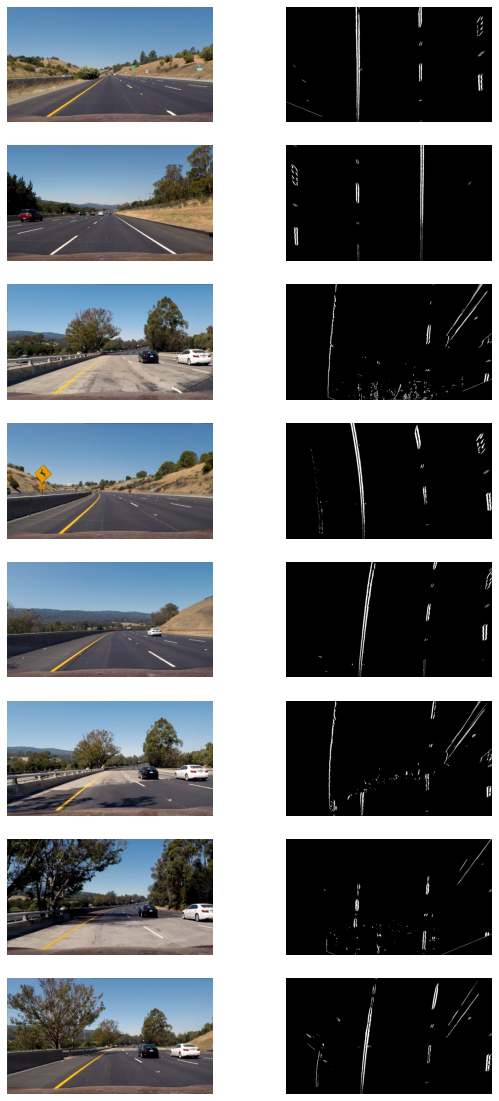

In [8]:
# Make a list of test images
images = glob.glob('test_images/*.jpg')

                                          
# Set up plot
f, axs = plt.subplots(len(images),2, figsize=(10, 20))
f.subplots_adjust(hspace = .2, wspace=.001)
axs = axs.ravel()
                  
a = 0
for image in images:
    img = mpimg.imread(image)
    img_bin, Minv = thresh_binary_pipeline(img)
    axs[a].imshow(img)
    axs[a].axis('off')
    a = a + 1
    axs[a].imshow(img_bin, cmap='gray')
    axs[a].axis('off')
    a = a + 1

## Detect lane pixels and fit the boundary

In [9]:
def find_lane_pixels(img):
    #Take a histogram of the bottom half of the image
    histogram = np.sum(img[img.shape[0]//2:,:],axis=0)
    #Find the peak of left and right halves of the histogram which will be starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]//2)
    #here we'll consider only quarter of image from midpoint on both side.
    quart_point = np.int(midpoint//2)
    leftx_base = np.argmax(histogram[quart_point:midpoint]) + quart_point
    rightx_base = np.argmax(histogram[midpoint: (midpoint+quart_point)]) + midpoint
    
    #Hyperparameters
    #choose the number of sliding windows
    nwindows = 9
    #set width of the windows +/- margin
    margin = 60
    #set minimum number of pixels found to recenter window
    minpix = 35
    #Set height of windows based on nwindows above and image shape
    window_height = np.int(img.shape[0]//nwindows)
    #Identify the x and y positions of all nonzero pixels in the image
    nonzero = img.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    
    #current positions to be updated for each window in nwindows
    leftx_current = leftx_base
    rightx_current = rightx_base
    #Create empty lists to receive left and right lane pixels indices
    left_lane_inds = []
    right_lane_inds = []
    #Rectangle data for visualisation
    rectangle_vertices = []
    
    #Steps through the windows one by one
    for window in range(nwindows):
        #Identify window boundaries in x and y (and right and left)
        win_y_low = img.shape[0] - (window+1) * window_height
        win_y_high = img.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin 
        rectangle_vertices.append((win_y_low,win_y_high,win_xleft_low,win_xleft_high,win_xright_low,win_xright_high))
        
        # Identify the nonzero pixels in x and y within the window#
        good_left_inds = ((nonzeroy>=win_y_low)&(nonzeroy<win_y_high)&(nonzerox>=win_xleft_low)&(nonzerox<win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy>=win_y_low)&(nonzeroy<win_y_high)&(nonzerox>=win_xright_low)&(nonzerox<win_xright_high)).nonzero()[0]
        #Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        #If you found >minpix pixels, recenter next window on this mean position
        if len(good_left_inds)>minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds)>minpix:
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))
            
    #Concatenate the array of indices(previously was lists of lists of pixels)
    try:
        left_lane_inds = np.concatenate(left_lane_inds)
        right_lane_inds = np.concatenate(right_lane_inds)
    except ValueError:
        #Avoids an error if the above is not implemented fully
        pass
     
    #Extract left and right lines pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds]
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]
    
    left_fit, right_fit = (None, None)
    #Fit second order polynomial#
    if len(leftx) != 0:
        left_fit = np.polyfit(lefty, leftx, 2)
    if len(rightx) != 0:
        right_fit = np.polyfit(righty, rightx, 2)
       
    return left_fit,right_fit,left_lane_inds, right_lane_inds,histogram, rectangle_vertices




#### Visualising sliding window polyfit

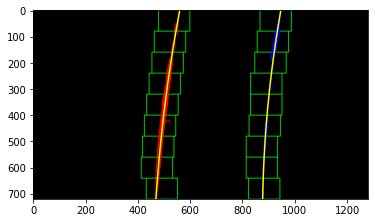

In [10]:
#visualize the result on test images
test_img = mpimg.imread("test_images/test6.jpg")
binary_warped, Minv = thresh_binary_pipeline(test_img)

left_fit, right_fit, left_lane_inds, right_lane_inds, histogram, rectangle_vertices = find_lane_pixels(binary_warped)

#Create an output image to draw on and visualize the result
out_img = np.uint8(np.dstack((binary_warped,binary_warped,binary_warped)))
#generate x and y values for plotting
ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0])
left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
right_fitx = right_fit[0]*ploty**2 + right_fit[1] *ploty + right_fit[2]

for vertex in rectangle_vertices:
    #Draw window on visualization image
    cv2.rectangle(out_img,(vertex[2],vertex[0]),(vertex[3],vertex[1]),(0,255,0),2)
    cv2.rectangle(out_img,(vertex[4],vertex[0]),(vertex[5],vertex[1]),(0,255,0),2)

# Identify the x and y positions of all nonzero pixels in the image
nonzero = binary_warped.nonzero()
nonzeroy = np.array(nonzero[0])
nonzerox = np.array(nonzero[1])
out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]
plt.imshow(out_img)
plt.plot(left_fitx, ploty, color='yellow')
plt.plot(right_fitx, ploty, color='yellow')

    

(0.0, 1280.0)

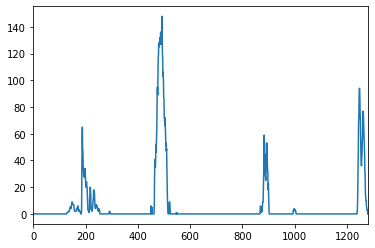

In [11]:
# Print histogram from sliding window polyfit 
plt.plot(histogram)
plt.xlim(0, 1280)

### Search around polynomial using fit from sliding window

In [12]:
def search_around_poly(binary_warped, left_fit, right_fit):
    #Hyperparameter
    #Choose the width of the margin around the previous polynomial
    margin = 60
    #Grab activated pixels
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    ##To-Do: Set the area of search based on activated x-values within the +/- margin of our polynomial function
    ##Hint: Consider the window areas for the similarly named variables in the previous quiz, but change the windows to our new search area
    left_lane_inds = ((nonzerox>(left_fit[0]*(nonzeroy**2)+ left_fit[1]*nonzeroy + left_fit[2]-margin))&(nonzerox<(left_fit[0]*(nonzeroy**2)+left_fit[1]*nonzeroy+left_fit[2]+margin)))
    right_lane_inds = ((nonzerox>(right_fit[0]*(nonzeroy**2)+right_fit[1]*nonzeroy+right_fit[2]-margin))&(nonzerox<(right_fit[0]*(nonzeroy**2)+right_fit[1]*nonzeroy+right_fit[2]+margin)))
    #Again extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds]
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]
    
    left_fit_current,right_fit_current = (None, None)
    if len(leftx) != 0:
        #Fit a second order polynomial to each
        left_fit_current = np.polyfit(lefty,leftx,2)
    if len(rightx) != 0:
        right_fit_current = np.polyfit(righty,rightx,2) 
    return left_fit_current,right_fit_current,left_lane_inds,right_lane_inds
    

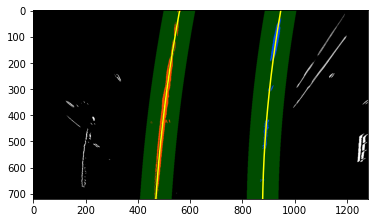

In [13]:
#Visualization#
test_img_1 = mpimg.imread('test_images/test6.jpg')
binary_warped, Minv = thresh_binary_pipeline(test_img_1)
    
left_fit_2, right_fit_2, left_lane_inds_2, right_lane_inds_2 = search_around_poly(binary_warped, left_fit, right_fit)
    
# Generate x and y values for plotting
ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0])
left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
left_fitx_2 = left_fit_2[0]*ploty**2 + left_fit_2[1]*ploty + left_fit_2[2]
right_fitx_2 = right_fit_2[0]*ploty**2 + right_fit_2[1]*ploty + right_fit_2[2]

    
#Create an image to draw on and an image to show the selection window
out_img = np.dstack((binary_warped,binary_warped,binary_warped))*255
window_img = np.zeros_like(out_img)
    
#Color in left and right line pixels
nonzero = binary_warped.nonzero()
nonzeroy = np.array(nonzero[0])
nonzerox = np.array(nonzero[1])
out_img[nonzeroy[left_lane_inds_2],nonzerox[left_lane_inds_2]] = [255,0,0]
out_img[nonzeroy[right_lane_inds_2],nonzerox[right_lane_inds_2]] = [0,0,255]
 
margin = 60    
#Generate a polygon to illustrate the search window area and recast the x and y points into usable format for cv2.fillPoly()
left_line_window1 = np.array([np.transpose(np.vstack([left_fitx-margin,ploty]))])
left_line_window2 = np.array([np.flipud(np.transpose(np.vstack([left_fitx+margin,ploty])))])
left_line_pts = np.hstack((left_line_window1,left_line_window2))
right_line_window1 = np.array([np.transpose(np.vstack([right_fitx-margin,ploty]))])
right_line_window2 = np.array([np.flipud(np.transpose(np.vstack([right_fitx+margin,ploty])))])
right_line_pts = np.hstack((right_line_window1,right_line_window2))

#Draw the lane onto warped blank image
cv2.fillPoly(window_img,np.int_([left_line_pts]),(0,255,0))
cv2.fillPoly(window_img,np.int_([right_line_pts]),(0,255,0))
result = cv2.addWeighted(out_img,1,window_img,0.3,0)
#Plot the polynomial lines onto the image
plt.plot(left_fitx_2,ploty,color='yellow')
plt.plot(right_fitx_2,ploty,color='yellow')
plt.imshow(result)
#End visualiztion#


##  Curvature of the lane and vehicle position with respect to center

In [14]:
def measure_curvature_real(binary_img,left_fit,right_fit,left_lane_inds,right_lane_inds):
    h = binary_img.shape[0]
    ym_per_pix = 3.048/100  # meters per pixel in y dimension 
    xm_per_pix = 3.7/400 # meters per pixel in x dimension [lane width in pixels= 866-466 =400]
    
    ploty = np.linspace(0, h-1, h)
    y_eval = np.max(ploty)
  
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_img.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    
    # Again, extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]
    
    if len(leftx) != 0 and len(rightx) != 0:
        # Fit new polynomials to x,y in world space
        left_fit_curve = np.polyfit(lefty * ym_per_pix, leftx * xm_per_pix, 2)
        right_fit_curve = np.polyfit(righty * ym_per_pix, rightx * xm_per_pix, 2)
        # Calculate the new radii of curvature
        left_curverad = ((1 + (2 * left_fit_curve[0] * y_eval * ym_per_pix + left_fit_curve[1])**2)** 1.5) / np.absolute(2 * left_fit_curve[0])
        right_curverad = ((1 + (2 * right_fit_curve[0] * y_eval * ym_per_pix + right_fit_curve[1])**2)** 1.5) / np.absolute(2 * right_fit_curve[0])
        # Now our radius of curvature is in meters
    
    # Distance from center is image x midpoint - mean of l_fit and r_fit intercepts 
    if right_fit is not None and left_fit is not None:
        mid_position = binary_img.shape[1]/2
        left_fit_x_inter = left_fit[0] * h**2 + left_fit[1] * h + left_fit[2]
        right_fit_x_inter = right_fit[0] * h**2 + right_fit[1] * h + right_fit[2]
        lane_center_position = (right_fit_x_inter + left_fit_x_inter) /2
        center_distance = (mid_position - lane_center_position) * xm_per_pix
    return left_curverad, right_curverad, center_distance

#### Calculate curvature and centre distance for test image

In [15]:
leftLane_rad, rightLane_rad, center_dist = measure_curvature_real(binary_warped, left_fit, right_fit, left_lane_inds, right_lane_inds)

print('Radius of curvature of the lane:', leftLane_rad, 'm,', rightLane_rad, 'm')
print('Distance from lane centre:', center_dist, 'm')

Radius of curvature of the lane: 592.3834398855688 m, 454.97697894700514 m
Distance from lane centre: -0.30766532457214285 m


#### Merge the detected lane into original image

In [16]:
def merge_lane_detected(real_img, bin_img, left_fit, right_fit, Minv):
    real_copy = np.copy(real_img)
    if left_fit is None or right_fit is None:
        return real_img
    #Create an image to draw the lines on
    unwarp_zero = np.zeros_like(bin_img).astype(np.uint8)
    color_unwarp = np.dstack((unwarp_zero, unwarp_zero, unwarp_zero))
    
    height,width = bin_img.shape
    ploty = np.linspace(0, height-1, height)# to cover same y-range as image
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))
   
    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_unwarp, np.int_([pts]), (0,255, 0))
    cv2.polylines(color_unwarp, np.int32([pts_left]), isClosed=False, color=(100,200,255), thickness=10)
    cv2.polylines(color_unwarp, np.int32([pts_right]), isClosed=False, color=(200,50,255), thickness=10)

    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    unwarp_bin = cv2.warpPerspective(color_unwarp, Minv, (width, height)) 
    # Combine the result with the original image
    result = cv2.addWeighted(real_copy ,0.9 , unwarp_bin, 0.4, 0)
    return result


#### Merge detected lane in test image

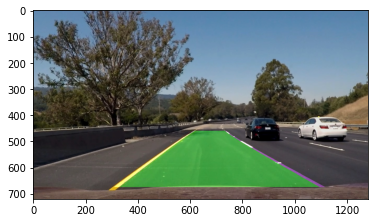

In [17]:
test_img_1_out = merge_lane_detected(test_img_1, binary_warped, left_fit, right_fit, Minv)

plt.imshow(test_img_1_out)

#### Write Radius and Center Distance data on the Original Image

In [18]:
def write_data(real_img, curve_rad, center_dist):
    real_copy = np.copy(real_img)
    h = real_copy.shape[0]
    font = cv2.FONT_HERSHEY_TRIPLEX
    text = 'Curve radius: ' + '{:04.2f}'.format(curve_rad) + 'm'
    cv2.putText(real_copy, text, (45,80), font, 1.5, (200,255,155), 2, cv2.LINE_AA)
    direction = ''
    if center_dist > 0:
        direction = 'right'
    elif center_dist < 0:
        direction = 'left'
    abs_center_dist = abs(center_dist)
    text = '{:04.3f}'.format(abs_center_dist) + 'm ' + direction + ' of center'
    cv2.putText(real_copy, text, (45,130), font, 1.5, (200,255,155), 2, cv2.LINE_AA)
    return real_copy

Write data on test image

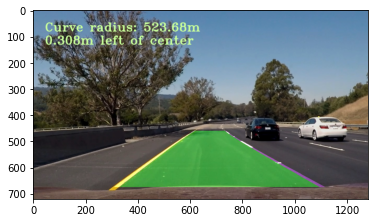

In [19]:
avg_curve_rad = (leftLane_rad + rightLane_rad)/2

test_img_2_out = write_data(test_img_1_out, avg_curve_rad, center_dist)
plt.imshow(test_img_2_out)

### Define a Lane Class for Data storage

In [20]:
# Define a class to store the details of each lane detection(for both left and right lane) in each iteration
class Lane_line():
    def __init__(self):
        #whether the lane found in the last iteration
        self.found = False  
         
        #average of polynomial coefficients over the last few iterations
        self.avg_fit = None  
        
        #polynomial coefficients for the most recent fit
        self.current_fit = []  
        
        #difference in fit coefficients between last and new fits
        self.diffs = np.array([0,0,0], dtype='float') 
        
        
    def add_poly_fit(self, poly_fit):
        # add a found fit to the lane
        if poly_fit is not None:
            if self.avg_fit is not None:
                # if we have a best avg fit, see how this new fit compares
                self.diffs = abs( poly_fit-self.avg_fit)
            if (self.diffs[0] > 0.001 or self.diffs[1] > 1.0 or self.diffs[2] > 100.) and len(self.current_fit) > 0:
                # bad fit
                # only if there are no fits in the current_fit queue, we'll take it
                self.found = False
            else:
                self.found = True
                self.current_fit.append(poly_fit)
                if len(self.current_fit) > 5:
                    # throw out old fits, keep newest n
                    self.current_fit = self.current_fit[len(self.current_fit)-5:]
                self.avg_fit = np.average(self.current_fit, axis=0)
                

        else:   #remove one from the history, if not found
            self.found = False
            if len(self.current_fit) > 0:
                # throw out oldest fit
                self.current_fit = self.current_fit[:len(self.current_fit)-1]
            if len(self.current_fit) > 0:    
                # if there are still any fits in the queue, best_fit is their average
                self.avg_fit = np.average(self.current_fit, axis=0)



### Final Image Processing Pipeline

In [21]:
def final_process_image(img):
    copy_img = np.copy(img)
    img_bin, Minv = thresh_binary_pipeline(copy_img)
    
    # if both left and right lanes were detected last frame, use polyfit_using_prev_fit, otherwise use sliding window
    if not left_lane.found or not right_lane.found:
        left_fit, right_fit, left_lane_inds, right_lane_inds, _, __ = find_lane_pixels(img_bin)
    else:
        left_fit, right_fit, left_lane_inds, right_lane_inds = search_around_poly(img_bin, left_lane.avg_fit, right_lane.avg_fit)
        
    # Reject both fits if the difference in their x-intercepts isn't around 350 px (+/- 100 px)
    if left_fit is not None and right_fit is not None:
        # calculate x-intercept (bottom of image, x=image_height) for fits
        h = img.shape[0]
        left_fit_x_inter = left_fit[0]*h**2 + left_fit[1]*h + left_fit[2]
        right_fit_x_inter = right_fit[0]*h**2 + right_fit[1]*h + right_fit[2]
        x_inter_diff = abs(right_fit_x_inter - left_fit_x_inter)
        if abs(350 - x_inter_diff) > 100:
            left_fit = None
            right_fit = None
            
    left_lane.add_poly_fit(left_fit)
    right_lane.add_poly_fit(right_fit)
    
    # draw the current best fit if it exists
    if left_lane.avg_fit is not None and right_lane.avg_fit is not None:
        img_final = merge_lane_detected(copy_img, img_bin, left_lane.avg_fit, right_lane.avg_fit, Minv)
        rad_left, rad_right, dist_center = measure_curvature_real(img_bin, left_lane.avg_fit, right_lane.avg_fit, left_lane_inds, right_lane_inds)
        img_out = write_data(img_final, (rad_left+rad_right)/2, dist_center)
    else:
        img_out = copy_img
    
    return img_out

### Process Project Video

In [22]:
left_lane = Lane_line()
right_lane = Lane_line()
video_output = 'project_video_output.mp4'
video_input = VideoFileClip('project_video.mp4')
processed_video = video_input.fl_image(final_process_image)
%time processed_video.write_videofile(video_output, audio=False)

t:   0%|                                                                            | 0/1260 [00:00<?, ?it/s, now=None]

Moviepy - Building video project_video_output.mp4.
Moviepy - Writing video project_video_output.mp4



Moviepy - Done !
Moviepy - video ready project_video_output.mp4
Wall time: 2min 31s


In [24]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(video_output))